In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import pairwise_distances
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import os
from sklearn.decomposition import PCA

In [2]:
import nltk
import string

def lower(word):
    return word.lower()

lemm = nltk.stem.WordNetLemmatizer()
def lemmatize(word):
    return lemm.lemmatize(word)

punct = set(string.punctuation)
def no_punctuation(word):
    return ''.join(c for c in word if c not in punct)

stop_words = set(nltk.corpus.stopwords.words("english"))
def no_stop_words(word):
    return word if word not in stop_words else ''

strategy_map = {'lo':lower,'lem':lemmatize,
                'punct':no_punctuation,'stop':no_stop_words}

def preprocess(docs,strategies):
    for strategy in strategies:
        new_docs = []
        for doc in docs:
            new_doc = []
            for word in doc:
                transformed = strategy_map[strategy](word)
                if transformed:
                    new_doc.append(transformed)
            new_docs.append(new_doc)
        docs = new_docs
    return docs

In [3]:
documents_train = []
for i in range(10000):
    with open('../descriptions_train/%d.txt' % (i,)) as f:
        documents_train.append(f.read().split())
documents_train = preprocess(documents_train,['lo','punct'])
documents_train_new = []
for i in range(10000):
    documents_train_new.append(TaggedDocument(documents_train[i],[i]))
documents_train = documents_train_new

In [4]:
model = Doc2Vec(documents_train, vector_size=100, window=10, 
                min_count=2, workers=4)

In [5]:
model.train(documents_train,total_examples=model.corpus_count,epochs=100)

In [6]:
documents_train[44]

TaggedDocument(words=['two', 'giraffes', 'in', 'a', 'room', 'with', 'people', 'looking', 'at', 'them', 'two', 'giraffe', 'standing', 'next', 'to', 'each', 'other', 'in', 'a', 'room', 'the', 'giraffe', 'is', 'being', 'kept', 'by', 'itself', 'indoors', 'a', 'man', 'and', 'woman', 'staring', 'at', 'two', 'giraffes', 'through', 'a', 'window', 'a', 'giraffe', 'in', 'a', 'enclosed', 'area', 'is', 'watched', 'by', 'some', 'people'], tags=[44])

In [7]:
model.wv.most_similar("dog",topn=12)

[('cat', 0.5911977291107178),
 ('boy', 0.5382112860679626),
 ('puppy', 0.5373006463050842),
 ('man', 0.5349361300468445),
 ('child', 0.5184822082519531),
 ('sandwich', 0.4895404875278473),
 ('hotdog', 0.48809492588043213),
 ('person', 0.4751810133457184),
 ('sheep', 0.46058911085128784),
 ('camera', 0.45980146527290344),
 ('dogs', 0.45729368925094604),
 ('house', 0.4548523426055908)]

In [8]:
text_train = np.array([model[i] for i in range(10000)])

In [9]:
text_test = np.zeros((2000,text_train.shape[1]))
documents_test = []
for i in range(2000):
    with open('../descriptions_test/%d.txt' % (i,)) as f:
        documents_test.append(f.read().split())
documents_test = preprocess(documents_test,['lo','punct'])
for i in range(2000):
    text_test[i] = model.infer_vector(documents_test[i])

In [10]:
text_train = np.hstack([text_train,np.ones((10000,1))])
text_test = np.hstack([text_test,np.ones((2000,1))])

In [11]:
text_train.shape,text_test.shape

((10000, 101), (2000, 101))

In [12]:
feats_train = pd.read_csv('../features_train/features_resnet1000intermediate_train.csv',header=None)
feats_train_b = pd.read_csv('../features_train/features_resnet1000_train.csv',header=None)
feats_test = pd.read_csv('../features_test/features_resnet1000intermediate_test.csv',header=None)
feats_test_b = pd.read_csv('../features_test/features_resnet1000_test.csv',header=None)

In [13]:
feats_train_b.head()

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,1000
0,images_train/5373.jpg,-0.899450,-0.930470,-2.503365,-3.172499,-2.819133,0.992159,-3.698863,0.619991,0.956148,...,-3.021916,2.214253,-1.382491,1.672911,1.014233,2.599949,2.773284,-2.066632,0.385754,-3.241320
1,images_train/984.jpg,-1.346954,-3.119461,-0.765971,-1.382550,-1.104675,-3.656271,-4.815436,-0.556942,-1.402286,...,0.011003,-3.968805,-2.694711,-4.196480,-2.880234,-1.210742,-1.605143,-4.859987,-0.837670,-0.967604
2,images_train/7127.jpg,-3.445498,-1.524573,-1.001654,-3.668335,-1.805517,-1.633496,-7.127826,-1.147802,-1.055816,...,-2.991777,-2.628053,-2.971074,-2.537039,-1.707429,1.013672,0.608460,-3.714998,-0.484735,0.138767
3,images_train/9609.jpg,1.114650,-2.167102,0.097881,-1.336255,0.853483,-0.374885,-2.369090,-2.273191,-1.143788,...,-1.248134,-0.633126,-1.723514,-2.638832,0.097149,4.647974,1.030138,-2.193836,1.044024,0.176043
4,images_train/5293.jpg,1.602650,-1.505817,3.029409,4.092412,1.711755,6.271253,4.173686,-2.177313,0.747789,...,-1.285806,-2.266481,-3.898053,2.295787,-1.749552,0.974188,1.258117,-1.975622,-1.278643,-1.941441


In [14]:
feats_train.shape,feats_test.shape

((10000, 2049), (2000, 2049))

In [15]:
pics_train = np.zeros((10000,3048))
for _,row in feats_train.iterrows():
    try:
        i = int(row[0].split('/')[1].split('.jpg')[0])
    except:
        i = int(row[0].split('/')[1].split('..jpg')[0])
    pics_train[i,:2048] = row.values[1:]
for _,row in feats_train_b.iterrows():
    try:
        i = int(row[0].split('/')[1].split('.jpg')[0])
    except:
        i = int(row[0].split('/')[1].split('..jpg')[0])
    pics_train[i,2048:] = row.values[1:]

In [16]:
pd.Series(pics_train.mean(0)).describe()

count    3048.000000
mean        0.286300
std         0.726504
min        -3.890733
25%         0.259784
50%         0.384236
75%         0.526699
max         4.441978
dtype: float64

In [17]:
pics_test = np.zeros((2000,3048))
for _,row in feats_test.iterrows():
    try:
        i = int(row[0].split('/')[1].split('.jpg')[0])
    except:
        i = int(row[0].split('/')[1].split('..jpg')[0])
    pics_test[i,:2048] = row.values[1:]
for _,row in feats_test_b.iterrows():
    try:
        i = int(row[0].split('/')[1].split('.jpg')[0])
    except:
        i = int(row[0].split('/')[1].split('..jpg')[0])
    pics_test[i,2048:] = row.values[1:]

In [18]:
pd.Series(pics_train.mean(0)).describe()

count    3048.000000
mean        0.286300
std         0.726504
min        -3.890733
25%         0.259784
50%         0.384236
75%         0.526699
max         4.441978
dtype: float64

In [19]:
tags_train = np.zeros((10000,100))
tags_test = np.zeros((2000,100))
tag_docs_train, tag_docs_test = [], []
for i in range(10000):
    with open('../tags_train/%d.txt' % (i,),'r') as f:
        tag_docs_train.append([word for line in f.read().split('\n') for word in line.split(':') if word])
for i in range(2000):
    with open('../tags_test/%d.txt' % (i,),'r') as f:
        tag_docs_test.append([word for line in f.read().split('\n') for word in line.split(':') if word])
tag_docs_train = preprocess(tag_docs_train,['lo','punct'])
tag_docs_test = preprocess(tag_docs_test,['lo','punct'])
for i in range(10000):
    tags_train[i] = model.infer_vector(tag_docs_train[i])
for i in range(2000):
    tags_test[i] = model.infer_vector(tag_docs_test[i])

In [20]:
tag_docs_train[0]

['vehicle',
 'airplane',
 'outdoor',
 'bench',
 'sports',
 'skateboard',
 'person',
 'person',
 'vehicle',
 'truck',
 'accessory',
 'backpack',
 'accessory',
 'handbag',
 'furniture',
 'dining table']

In [21]:
pd.Series(np.abs(tags_test.mean(1))).describe()

count    2000.000000
mean        0.104557
std         0.094489
min         0.000024
25%         0.043323
50%         0.079362
75%         0.129851
max         0.671635
dtype: float64

In [22]:
pics_train = np.hstack([pics_train,tags_train])
pics_test = np.hstack([pics_test,tags_test])

In [23]:
pics_train.shape,pics_test.shape

((10000, 3148), (2000, 3148))

In [24]:
pca = PCA(n_components=101)
pca.fit(pics_train)
pics_train = pca.transform(pics_train)
pics_test = pca.transform(pics_test)

In [25]:
pics_train.shape,pics_test.shape

((10000, 101), (2000, 101))

In [26]:
def get_gradient(texts,W,labels,reg=.05):
    return 2*texts.T.dot(texts.dot(W)-labels)# + 2*reg*W

def get_prediction(texts,W,pics):
    vecs = np.dot(texts,W)
    dists = pairwise_distances(vecs,pics,metric='cosine')
    return dists.argsort(1)#[:,:20]

W = np.random.random((text_train.shape[1],pics_train.shape[1]))
learning_rate = 3e-5
batch_size = 15
n_epochs = 2800
for i in range(n_epochs):
    losses = np.array([])
    if (i+1)%14==0:
        errors = np.array([])
    for batch_start in np.arange(0,9999,batch_size):
        #print(batch_start)
        losses = np.concatenate([losses,
                                 np.linalg.norm(text_train[batch_start:batch_start+batch_size].dot(W)-
                                                pics_train[batch_start:batch_start+batch_size],axis=1)])
        if (i+1)%14==0:
            preds = get_prediction(text_train[batch_start:batch_start+batch_size],W,pics_train)
            errors = np.concatenate([errors,np.array([np.argwhere(vec==i+batch_start)[0][0]
                                                      for i,vec in enumerate(preds)])])
        W -= learning_rate*get_gradient(text_train[batch_start:batch_start+batch_size],W,
                                        pics_train[batch_start:batch_start+batch_size])
    if (i+1)%14==0:
        print(i,learning_rate,np.mean(losses),np.mean(errors))
    else:
        print(i,learning_rate,np.mean(losses))
    if (i+1)%7==0:
        learning_rate /= 1.2

0 3e-05 70.80084232619728
1 3e-05 61.591947643459555
2 3e-05 58.10161895746675
3 3e-05 56.59008587525474
4 3e-05 55.855040460644084
5 3e-05 55.458096000237404
6 3e-05 55.22533374272422
7 2.5e-05 55.070988269379
8 2.5e-05 54.98631198482703
9 2.5e-05 54.92558500832548
10 2.5e-05 54.88103856837386
11 2.5e-05 54.84774000882743
12 2.5e-05 54.8224340348887
13 2.5e-05 54.802915142558724 840.6887
14 2.0833333333333336e-05 54.77328425972449
15 2.0833333333333336e-05 54.762399509389724
16 2.0833333333333336e-05 54.753539934675025
17 2.0833333333333336e-05 54.74617989663591
18 2.0833333333333336e-05 54.74000989299041
19 2.0833333333333336e-05 54.734795082400936
20 2.0833333333333336e-05 54.73035400533144
21 1.7361111111111114e-05 54.71374387910564
22 1.7361111111111114e-05 54.71056541329353
23 1.7361111111111114e-05 54.70792670532132
24 1.7361111111111114e-05 54.70560336604982
25 1.7361111111111114e-05 54.703539904548016
26 1.7361111111111114e-05 54.70169454291286
27 1.7361111111111114e-05 54.700

KeyboardInterrupt: 

In [42]:
pd.Series(np.abs(W.mean(0))).describe()

count    3048.000000
mean        0.008615
std         0.004482
min         0.000008
25%         0.005583
50%         0.008275
75%         0.010943
max         0.029375
dtype: float64

In [66]:
pd.Series(W.mean(0)[-100:]).describe()

count    100.000000
mean       0.010704
std        0.003993
min       -0.001207
25%        0.007448
50%        0.010790
75%        0.013579
max        0.021672
dtype: float64

In [2]:
W = np.load('W.npy')

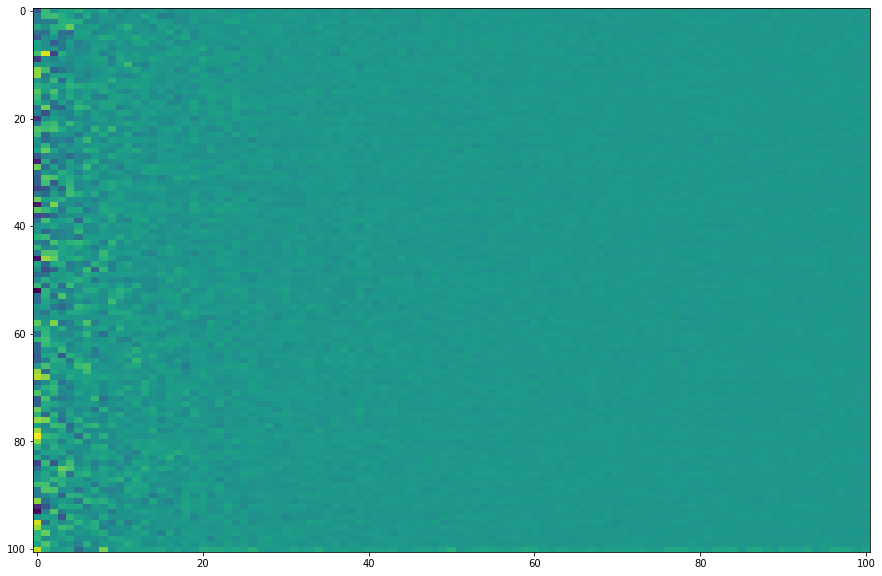

In [83]:
fig,ax = plt.subplots(1,1,figsize=(15,10))
plt.imshow(W,aspect='auto');

In [16]:
pd.Series(np.ravel(np.abs(W[:100,:-100]))).describe()

count    3.048000e+05
mean     4.330217e-02
std      5.605302e-02
min      2.187012e-08
25%      1.032491e-02
50%      2.317796e-02
75%      4.949967e-02
max      8.281206e-01
dtype: float64

In [17]:
pd.Series(np.ravel(np.abs(W[:100,-100:]))).describe()

count    1.000000e+04
mean     3.892936e-02
std      3.217882e-02
min      3.763162e-07
25%      1.463631e-02
50%      3.115677e-02
75%      5.473252e-02
max      2.788267e-01
dtype: float64

In [84]:
preds = get_prediction(text_test,W,pics_test)

In [87]:
preds.shape

(2000, 2000)

In [90]:
def get_top_20(descr_id):
    return preds[descr_id][:20]

def save_submission():
    data = []
    for i in range(2000):
        data.append(['%d.txt' % (i,),' '.join('%d.jpg' % (pic_id,) for pic_id in get_top_20(i))])
    pd.DataFrame(data,columns=['Descritpion_ID','Top_20_Image_IDs']).to_csv('submission.csv',index=False)

In [91]:
save_submission()

In [93]:
preds[16][:20]

array([  87, 1850,  305, 1127, 1018,  172,  914, 1974,   52,  620,  673,
       1913,  256,  289, 1433, 1882, 1154, 1243,   68, 1888])

In [30]:
get_prediction(text_train[0:5],W,pics_train)

array([[7026, 6745, 6578, 5185,  631,  456, 8957, 3506, 8171, 9280,  808,
        8268, 8126, 1472, 5899, 2254, 2963, 5766, 3199, 4587],
       [8362, 7509, 4768, 9001, 8398, 3893, 5714, 7510, 8072, 7100, 3706,
        9702, 4289, 6521, 1045,  563, 9328, 3575, 3619, 9461],
       [5899, 8171, 9573, 2990,  265, 1472, 9960, 2935, 9280, 2254, 4623,
        3666,  686, 6414,  956,  808,  153, 2853, 2958, 9400],
       [9280, 1472, 9139,  686,  808, 9573, 8490, 1537, 3028, 6840, 2398,
        8885, 9505, 9400, 1311, 4215, 3728, 7473, 4334, 2717],
       [4305, 4215, 9280, 4438, 4118,  468,  865, 8135, 9698,  349, 9573,
        3504, 3013, 4886, 8469, 6840, 1016, 2064, 5071, 3731]])

In [94]:
preds = get_prediction(text_train,W,pics_train)

In [100]:
sum(i in set(arr[:20]) for i,arr in enumerate(preds))

599

In [105]:
len([i for i,arr in enumerate(preds) if i in set(arr[:1])])

61

In [107]:
preds[171]

array([ 171, 4985, 3419, ..., 6170, 8267, 5293])

In [106]:
[i for i,arr in enumerate(preds) if i in set(arr[:1])]

[171,
 198,
 562,
 633,
 688,
 830,
 890,
 1166,
 1618,
 2227,
 2437,
 2528,
 2649,
 2808,
 3135,
 3251,
 3260,
 3336,
 3376,
 3575,
 3586,
 3608,
 3642,
 4019,
 4243,
 4342,
 4377,
 4559,
 4667,
 4878,
 5139,
 5391,
 5461,
 5552,
 5575,
 5641,
 5905,
 5985,
 6071,
 6303,
 6408,
 6794,
 6862,
 7078,
 7123,
 7473,
 7769,
 8014,
 8107,
 8171,
 8364,
 8548,
 8563,
 8598,
 9034,
 9150,
 9280,
 9348,
 9356,
 9461,
 9829]

In [109]:
len([i for i,arr in enumerate(preds) if i not in set(arr[:300])])

6922

In [111]:
preds[0]

array([ 657, 1450,  979, ..., 7527, 3974, 5293])

In [110]:
[i for i,arr in enumerate(preds) if i not in set(arr[:300])]

[0,
 1,
 3,
 6,
 7,
 9,
 11,
 12,
 13,
 14,
 17,
 18,
 19,
 22,
 23,
 25,
 26,
 27,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 50,
 51,
 52,
 54,
 57,
 58,
 59,
 60,
 62,
 63,
 64,
 65,
 66,
 67,
 69,
 70,
 71,
 72,
 73,
 74,
 76,
 77,
 78,
 79,
 80,
 84,
 85,
 87,
 88,
 89,
 90,
 92,
 94,
 96,
 97,
 98,
 102,
 103,
 104,
 106,
 107,
 108,
 109,
 111,
 112,
 113,
 115,
 116,
 117,
 118,
 120,
 121,
 122,
 124,
 125,
 127,
 128,
 129,
 130,
 132,
 133,
 134,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 147,
 148,
 150,
 151,
 152,
 154,
 155,
 156,
 157,
 159,
 161,
 162,
 163,
 166,
 167,
 168,
 169,
 172,
 174,
 176,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 189,
 190,
 191,
 192,
 193,
 194,
 195,
 196,
 200,
 202,
 203,
 204,
 206,
 207,
 208,
 209,
 210,
 211,
 212,
 215,
 216,
 219,
 220,
 222,
 224,
 226,
 228,
 229,
 230,
 231,
 233,
 234,
 236,
 237,
 238,
 242,
 243,
 244,
 245,
 246,
 247,
 249,
 250,